---
skip_execution: true
---

# Solving PDE-based BIP using core CUQIpy


Here we build a Bayesian problem in which the forward model is a partial differential equation (PDE) model, the 1D heat problem in particular.

**Try to at least run through part 1 to 3 before working on the optional exercises.**

## Learning objectives of this notebook:
- Solve PDE-based Bayesian problem using CUQIpy.
- Use different parametrizations of the Bayesian parameters (e.g. KL expansion, non-linear maps).

## Table of contents: 
* [1. Loading the PDE test problem](#PDE_model)
* [2. Building and solving the Bayesian inverse problem](#inverse_problem)
* [3. Parametrizing the unknown parameters via step function expansion](#step_function)
* [4. ★ Observe on part of the domain](#Partial_Observation) 
* [5. ★ Parametrizing the unknown parameters via KL expansion](#KL_expansion)

★ Indicates optional section.

<div style="border: 2px solid #FFB74D; background-color: #FFF3E0; border-radius: 8px; padding: 10px; font-family: Arial, sans-serif; color: #333; box-shadow: 2px 2px 8px rgba(0, 0, 0, 0.1); max-width: 750px; margin: 0 auto;">
  <strong style="color: #E65100;">⚠️ Note:</strong> 
  
 - This notebook was run on a local machine and not using github actions for this book due to its long execution time.

</div>

##  1. Loading the PDE test problem <a class="anchor" id="PDE_model"></a>

We first import the required python standard packages that we need:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import floor
import cuqi

# Disable progress bar dynamic update of sampling acceptance rate for cleaner
# output for the book. You can enable it again by setting it to True to monitor
# sampler acceptance rate progress.
cuqi.config.PROGRESS_BAR_STATS_DYNAMIC_UPDATE = False

From CUQIpy we import the classes that we use in this exercise:

In [2]:
from cuqi.testproblem import Heat1D
from cuqi.distribution import Gaussian, JointDistribution
from cuqi.sampler import PCN, MH, CWMH

We load the test problem `Heat1D` which provides a one dimensional (1D) time-dependent heat model with zero boundary conditions. The model is discretized using finite differences.

The PDE is given by:

$$ \frac{\partial u(\xi,\tau)}{\partial \tau} - c^2 \Delta_\xi u(\xi,\tau)   = f(\xi,\tau), \;\text{in}\;[0,L] $$
$$u(0,\tau)= u(L,\tau)= 0 $$

where $u(\xi,\tau)$ is the temperature and $c^2$ is the thermal diffusivity (assumed to be 1 here). We assume the source term $f$ is zero. The unknown parameters (random variable) for this test problem is the initial heat profile $g(\xi):=u(\xi,0)$.

The data $y$ is a random variable containing the temperature measurements everywhere in the domain at the final time $\tau^\mathrm{max}$ corrupted by Gaussian noise:

$$
y = \mathcal{G}(g) + \eta, \;\;\; \eta\sim\mathrm{Gaussian}(0,\sigma_\text{noise}^2\mathbf{I}),
$$ 

where $\mathcal{G}(g)$ is the forward model that maps the initial condition $g$ to the final time solution via solving the 1D time-dependent heat problem. $\eta$ is the measurement noise.

Given observed data $y^\text{obs}$ the task is to infer the initial heat profile $g$.

Before we load the `Heat1D` problem, let us set the parameters: final time $\tau^\mathrm{max}$, number of finite difference nodes $N$, and the length of the domain $L$

In [3]:
N = 30    # Number of finite difference nodes            
L = 1     # Length of the domain
tau_max = 0.02  # Final time

We assume that the exact initial condition that we want to infer is a step function with three pieces. Here we use regular Python and NumPy functions to define the initial condition.

In [4]:
n_steps = 3
n_steps_values = [0,1,2]
myExactSolution = np.zeros(N)

start_idx=0
for i in range(n_steps):
    end_idx = floor((i+1)*N/n_steps)
    myExactSolution[start_idx:end_idx] = n_steps_values[i]
    start_idx = end_idx

We plot the exact solution for each node $\xi_i$:

Text(0.5, 0, 'i')

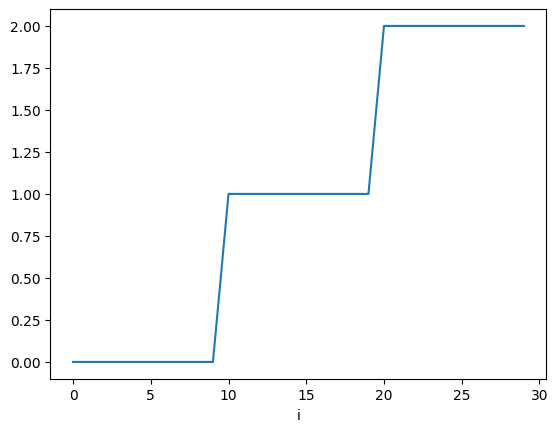

In [5]:
plt.plot(myExactSolution)
plt.xlabel("i")

While it is possible to create a PDE model from scratch, for this notebook we use the `Heat1D` test problem that is already implemented in CUQIpy.

We may extract components of a `Heat1D` instance by calling the `get_components` method.

In [6]:
model, data, problemInfo = Heat1D(
    dim=N, 
    endpoint=L, 
    max_time=tau_max, 
    exactSolution=myExactSolution
).get_components()

Let us take a look at what we obtain from the test problem. We view the `model`:

In [7]:
model

CUQI PDEModel: Continuous1D[30] -> Continuous1D[30].
    Forward parameters: ['x'].
    PDE: TimeDependentLinearPDE.

Note that the forward model parameter, named `x` here, is the unknown parameter which we want to infer. It represents the initial condition $g$ above, or a a parameterization of it. 


We can look at the returned `data`:

In [8]:
data

CUQIarray: NumPy array wrapped with geometry.
---------------------------------------------

Geometry:
 Continuous1D[30]

Parameters:
 True

Array:
CUQIarray([0.03939676, 0.07368239, 0.12141802, 0.12520728, 0.15403253,
           0.26915817, 0.30853755, 0.31895821, 0.44252805, 0.52301569,
           0.55362164, 0.70725983, 0.77107438, 0.83816592, 0.93158   ,
           1.01966775, 1.09120576, 1.18585076, 1.20560493, 1.2202887 ,
           1.25098578, 1.25508846, 1.23632261, 1.18214083, 1.0830265 ,
           0.95198535, 0.83955182, 0.63287529, 0.44510474, 0.19922157])

And the `problemInfo`:

In [9]:
problemInfo

ProblemInfo with the following set attributes:
['exactSolution', 'infoString', 'exactData']
 infoString: Noise type: Additive i.i.d. noise with mean zero and signal to noise ratio: 200

Now let us plot the exact solution (exact initial condition) of this inverse problem and the exact and noisy data (the final time solution before and after adding observation noise):

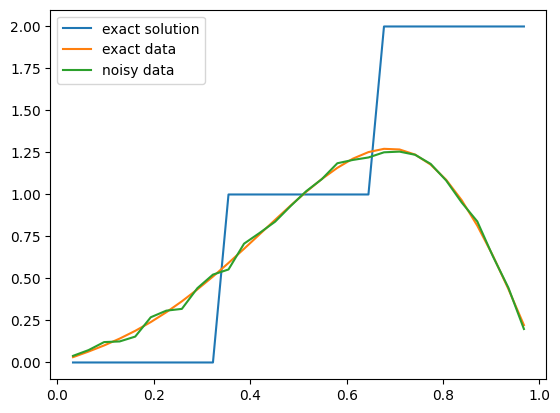

In [10]:
problemInfo.exactSolution.plot()
problemInfo.exactData.plot()
data.plot()
plt.legend(['exact solution', 'exact data', 'noisy data']);

Note that the values of the initial solution and the data at 0 and $L$ are not included in this plot.


#### Try yourself (optional)
* The data plotted above was generated from the model. Confirm that the model actually generates this data (the exact data) by applying `model.forward` on the exact solution (the initial heat profile).

In [11]:
# Your code here



* Can you view the heat profile at time $\tau= 0.001$? At $0.002, 0.003, ..., 0.02$? What do you notice? (hint: you can do that by choosing different final time when loading `Heat1D`).

In [12]:
# Your code here



In case the parameters were changed in the exercise, we reset them here

In [13]:
N = 30    # Number of finite difference nodes            
L = 1     # Length of the domain
tau_max = 0.02  # Final time
model, data, problemInfo = Heat1D(
    dim=N, 
    endpoint=L, 
    max_time=tau_max, 
    exactSolution=myExactSolution
).get_components()

## 2. Building and solving the Bayesian inverse problem <a class="anchor" id="inverse_problem"></a>

The joint distribution of the data $y$ and the parameter $x$ (where $x$ represents the unknown values of the initial condition $g$ at the grid nodes in this section) is given by

$$p(x,y) = p(y|x)p(x)$$



Where $p(x)$ is the prior pdf, $p(y|x)$ is the data distribution pdf (likelihood). We start by defining the prior distribution $p(x)$:

In [14]:
mean = 0
std = 1.2
x = Gaussian(mean, cov=std**2, geometry=model.domain_geometry) # The prior distribution


#### Try yourself (optional)
* Create prior samples.
* Plot the $95\%$ credibility interval of the prior samples.
* Look at the $95\%$ credibility interval of the PDE model solution to quantify the forward uncertainty.


In [15]:
# Your code here



To define the data distribution $p(y|x)$, we first estimate the noise level. Because here we know the exact data, we can estimate the noise level as follows:

In [16]:
sigma_noise = np.std(problemInfo.exactData - data)*np.ones(model.range_dim) # noise level

And then define the data distribution $p(y|x)$: 

In [17]:
y = Gaussian(mean=model(x), cov=sigma_noise**2, geometry=model.range_geometry)

Now that we have all the components we need, we can create the joint distribution $p(x,y)$, from which the posterior distribution can be created by setting $y=y^\text{obs}$ (we named the observed data as `data` in our code):

First, we define the joint distribution $p(x,y)$:

In [18]:
joint = JointDistribution(y, x)
print(joint)

JointDistribution(
    Equation: 
	p(y,x) = p(y|x)p(x)
    Densities: 
	y ~ CUQI Gaussian. Conditioning variables ['x'].
	x ~ CUQI Gaussian.
 )


The posterior distribution pdf is given by the Bayes rule:
$$ 
p(x|y=y^\text{obs}) \propto p(y=y^\text{obs}|x)p(x) 
$$ 
By setting $y=\texttt{data}$ in the joint distribution we obtain the posterior distribution:

In [19]:
posterior = joint(y=data)
print(posterior)

Posterior(
    Equation:
	 p(x|y) ∝ L(x|y)p(x)
    Densities:
	y ~ CUQI Gaussian Likelihood function. Parameters ['x'].
 	x ~ CUQI Gaussian.
 )


We can now sample the posterior. Let's try the preconditioned Crank-Nicolson (pCN) sampler (~40 seconds):

In [20]:
MySampler = PCN(posterior, scale=0.01)
MySampler.warmup(10000, tune_freq=0.01)
MySampler.sample(20000)
posterior_samples = MySampler.get_samples()

Warmup: 100%|██████████| 10000/10000 [00:13<00:00, 756.42it/s]


Acceptance rate: 48.32%


Sample: 100%|██████████| 20000/20000 [00:27<00:00, 739.76it/s]

Acceptance rate: 45.62%


Note here we use the `warmup` sampling method for the entire sampling run and we set the tuning frequency to 0.01, which means that the scale of the proposal distribution is adapted every 1% of the samples.


Let's look at the $95\%$ credible interval:

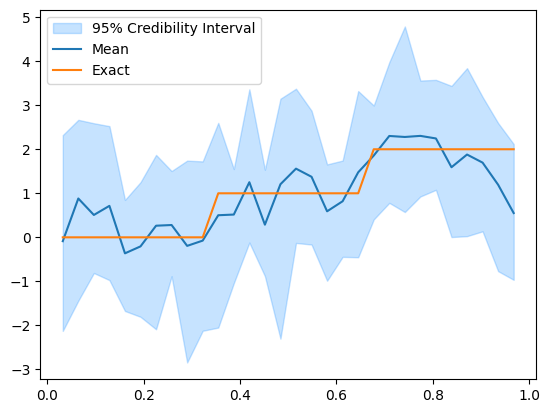

In [21]:
posterior_samples.plot_ci(95, exact=problemInfo.exactSolution)

We can see that the mean reconstruction of the initial solution matches the general trend of the exact solution to some extent but it does not capture the piece-wise constant nature of the exact solution.

Also we note that since the heat problem has zero boundary conditions, the initial solution reconstruction tend to go to zero at the right boundary. 

## 3. Parametrizing the unknown parameters via step function expansion <a class="anchor" id=" step_function"></a> 

One way to improve the solution of this Bayesian problem is to use better prior information. Here we assume the prior is a step function with three pieces (which is exactly how we created the exact solution). This also makes the Bayesian inverse problem simpler because now we only have three unknown parameters to infer.

To test this case we pass `field_type='Step'` to the constructor of `Heat1D`, which creates a `StepExpansion` domain geometry for the model during initializing the `Heat1D` test problem. It is also possible to change the domain geometry manually after initializing the test problem, but we will not do that here. 

The parameter `field_params` is a dictionary that is used to pass keyword arguments that the underlying domain field geometry accepts. For example `StepExpansion` has a keyword argument `n_steps` and thus we can set `field_params={'n_steps': 3}`.

In [22]:
n_steps = 3 # number of steps in the step expansion domain geometry
N = 30
model, data, problemInfo = Heat1D(
    dim=N,
    endpoint=L,
    max_time=tau_max,
    field_type="Step",
    field_params={"n_steps": n_steps},
    exactSolution=myExactSolution,
).get_components()


Let's look at the `model` in this case: 

In [23]:
model

CUQI PDEModel: StepExpansion[3: 30] -> Continuous1D[30].
    Forward parameters: ['x'].
    PDE: TimeDependentLinearPDE.

We then continue to create the Bayesian inverse problem (prior, data distribution and then posterior) with a prior of dimension = n_steps. 

In [24]:
# Prior
x = Gaussian(mean, std**2, geometry=model.domain_geometry)

# Data distribution
sigma_noise = np.std(problemInfo.exactData - data)*np.ones(model.range_dim) # noise level
y = Gaussian(mean=model(x), cov=sigma_noise**2, geometry=model.range_geometry)

And the posterior:

In [25]:
joint =  JointDistribution(y, x)
posterior = joint(y=data)

We then sample the posterior using Metropolis Hastings `MH` sampler (~40 seconds)

In [26]:
MySampler = MH(posterior, scale=0.01)
MySampler.warmup(10000, tune_freq=0.01)
MySampler.sample(20000)
posterior_samples = MySampler.get_samples()

Warmup: 100%|██████████| 10000/10000 [00:10<00:00, 946.64it/s]


Acceptance rate: 24.88%


Sample: 100%|██████████| 20000/20000 [00:26<00:00, 742.27it/s]

Acceptance rate: 24.30%


Let's take a look at the posterior:

(3, 30000)

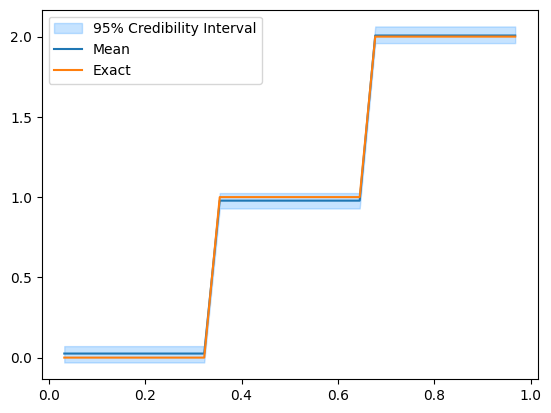

In [27]:
posterior_samples.plot_ci(95, exact=problemInfo.exactSolution)
posterior_samples.shape

We show the trace plot: a plot of the kernel density estimator (left) and chains (right) of the `n_steps` variables:

array([[<Axes: title={'center': 'x0'}>, <Axes: title={'center': 'x0'}>],
       [<Axes: title={'center': 'x1'}>, <Axes: title={'center': 'x1'}>],
       [<Axes: title={'center': 'x2'}>, <Axes: title={'center': 'x2'}>]],
      dtype=object)

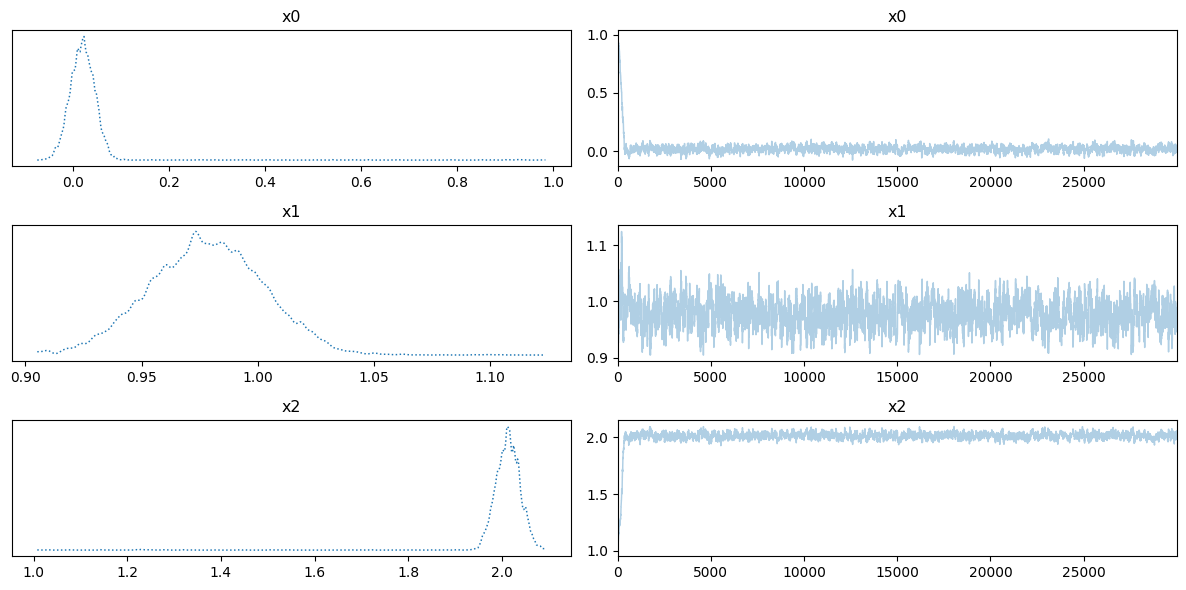

In [28]:
posterior_samples.plot_trace()

We show pair plot of 2D marginal posterior distributions: 

array([[<Axes: ylabel='x1'>, <Axes: >],
       [<Axes: xlabel='x0', ylabel='x2'>, <Axes: xlabel='x1'>]],
      dtype=object)

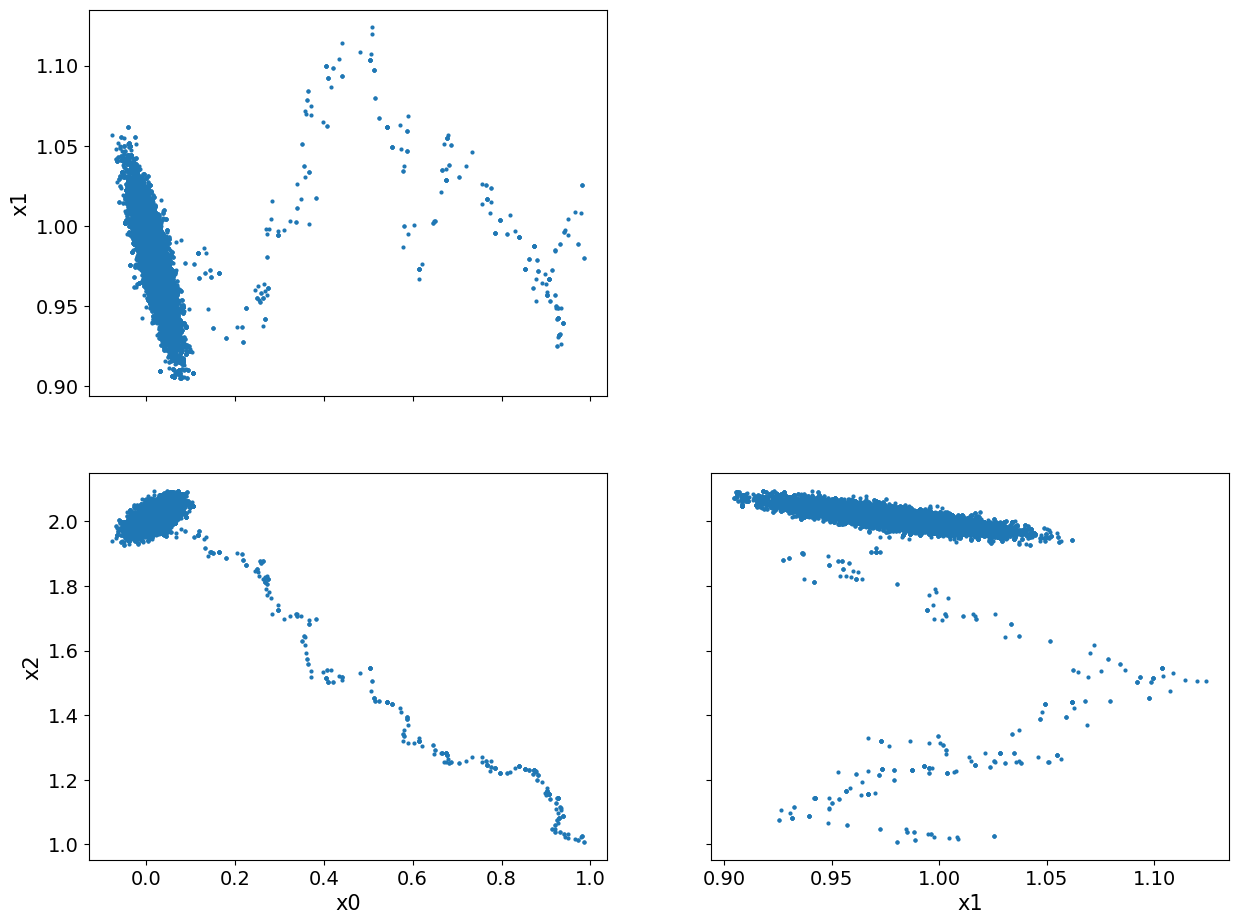

In [29]:
posterior_samples.plot_pair()

We notice that there seems to be some burn-in samples until the chain reaches the high density region. We show the pair plot after removing 1000 burn-in:

array([[<Axes: ylabel='x1'>, <Axes: >],
       [<Axes: xlabel='x0', ylabel='x2'>, <Axes: xlabel='x1'>]],
      dtype=object)

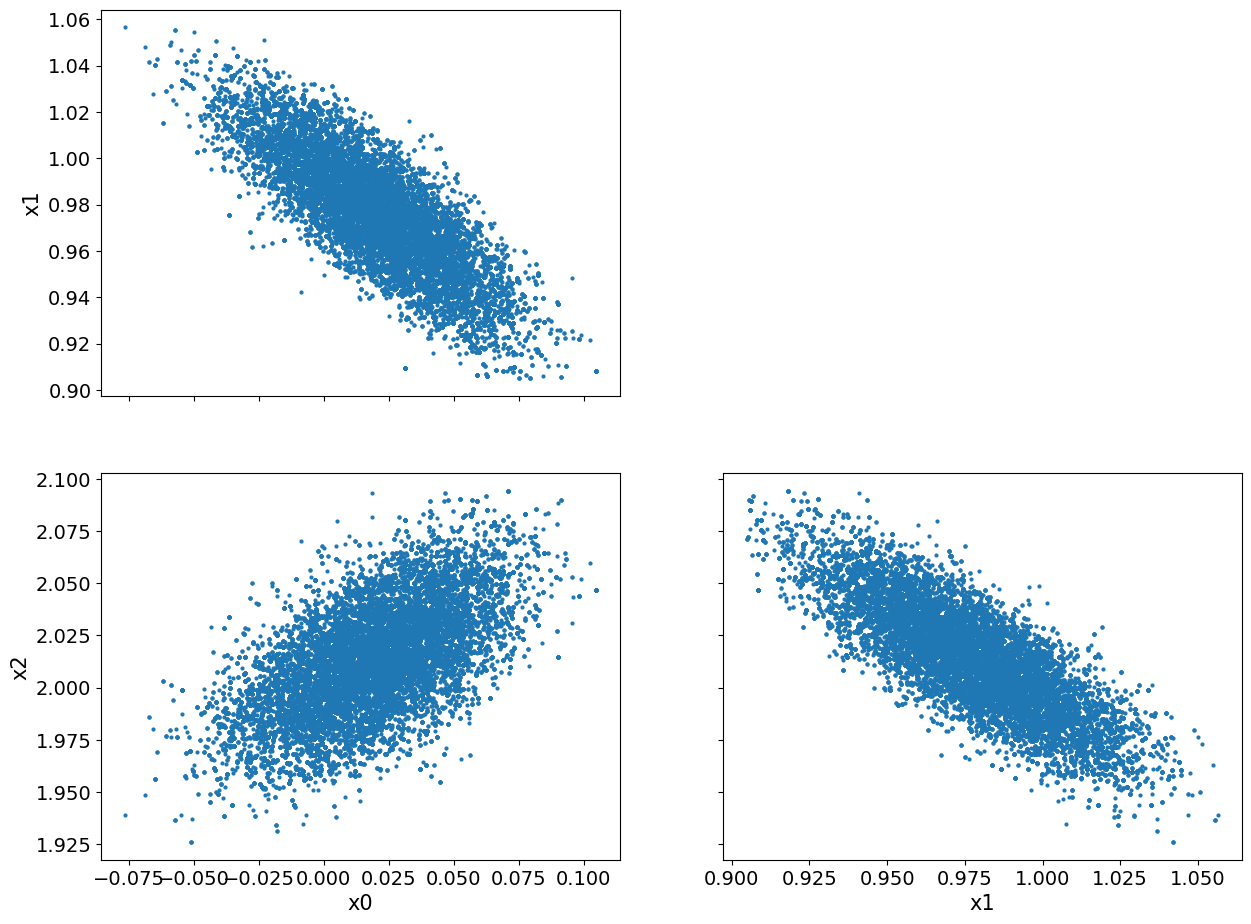

In [30]:
posterior_samples.burnthin(1000).plot_pair()

We can see that, visually, the burn-in is indeed removed. Another observation here is the clear correlation (or inverse correlation) between each pair of the variables.

We can also see the effect of removing the burn-in if we look at the $100\%$ credible interval before and after removing the burn-in. Let us look at the $100\%$ credible interval before:

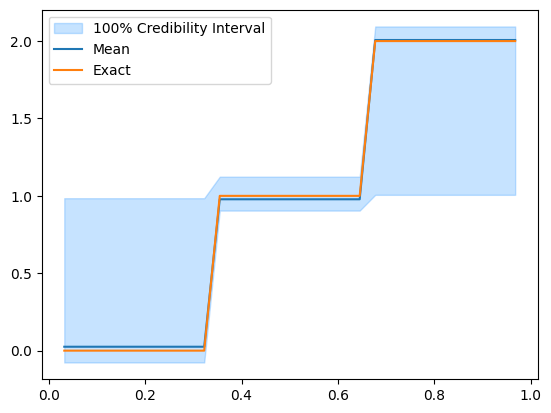

In [31]:
posterior_samples.plot_ci(100, exact=problemInfo.exactSolution)

And after removing the burn-in:

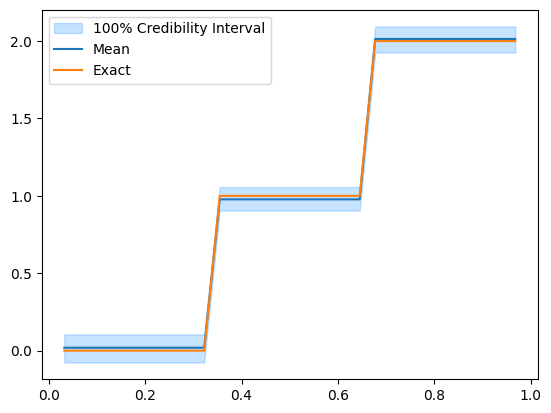

In [32]:
posterior_samples.burnthin(1000).plot_ci(100, exact=problemInfo.exactSolution)

We compute the effective sample size (ESS) which approximately gives the number of independent samples in the chain:

In [33]:
posterior_samples.compute_ess()

array([503.96279336, 571.46982169, 476.80823864])

#### Try it yourself (optional):
* For this step function parametrization, try to enforce positivity of prior and the posterior samples via log parametrization which can be done by initialing `Heat1D` with `map = lambda x : np.exp(x)`. Then run the Metropolis Hastings sampler again (similar to part 3).

In [34]:
# Your code here



## 4. ★ Observe on part of the domain <a class="anchor" id="Partial_Observation"></a> 

Here we solve the same problem as in section 3 but with observing the data only on the right half of the domain.  

We chose the number of steps to be 4:

In [35]:
N = 30
n_steps = 4 # Number of steps in the StepExpansion geometry. 

Then we write the `observation_nodes` map which can be passed to the `Heat1D`.
It is a lambda function that takes the forward model range grid (`range_grid`) as an input and generates a sub grid of the nodes where we have observations (data). 

In [36]:
# observe in the right half of the domain
observation_nodes = lambda range_grid: range_grid[np.where(range_grid>L/2)] 

We load the `Heat1D` problem. Note in this case we do not pass an `exactSolution`. If no `exactSolution` is passed, the `Heat1D` test problem will create an exact solution.

In [37]:
model, data, problemInfo = Heat1D(
    dim=N,
    endpoint=L,
    max_time=tau_max,
    field_type="Step",
    field_params={"n_steps": n_steps},
    observation_grid_map=observation_nodes,
).get_components()


Now let us plot the exact solution of this inverse problem and the exact and noisy data:

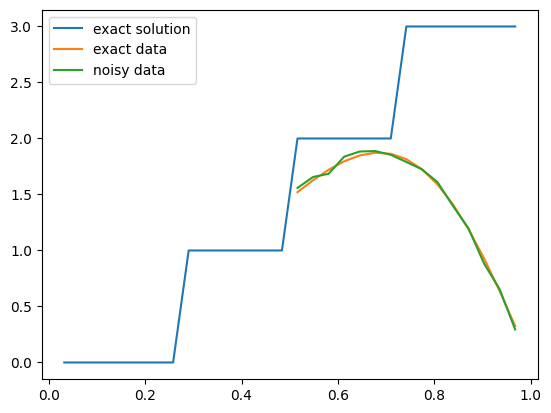

In [38]:
problemInfo.exactSolution.plot()
problemInfo.exactData.plot()
data.plot()
plt.legend(['exact solution', 'exact data', 'noisy data']);

We then continue to create the Bayesian inverse problem (prior, data distribution and then posterior) with a prior of dimension = 4. 

In [39]:
# Prior
x = Gaussian(1, std**2, geometry=model.domain_geometry)

# Data distribution
sigma_noise = np.std(problemInfo.exactData - data)*np.ones(model.range_dim) # noise level
y = Gaussian(mean=model(x), cov=sigma_noise**2, geometry=model.range_geometry)

And the posterior:

In [40]:
joint =  JointDistribution(y, x)
posterior = joint(y=data)

We then sample the posterior using the Metropolis Hastings sampler (~50 seconds)

In [41]:
MySampler = MH(posterior, initial_point=np.ones(posterior.dim), scale=0.01)
MySampler.warmup(10000, tune_freq=0.01)
MySampler.sample(20000)
posterior_samples = MySampler.get_samples()

Warmup: 100%|██████████| 10000/10000 [00:13<00:00, 765.55it/s]


Acceptance rate: 28.32%


Sample: 100%|██████████| 20000/20000 [00:33<00:00, 594.31it/s]

Acceptance rate: 23.18%


Let's take a look at the posterior:

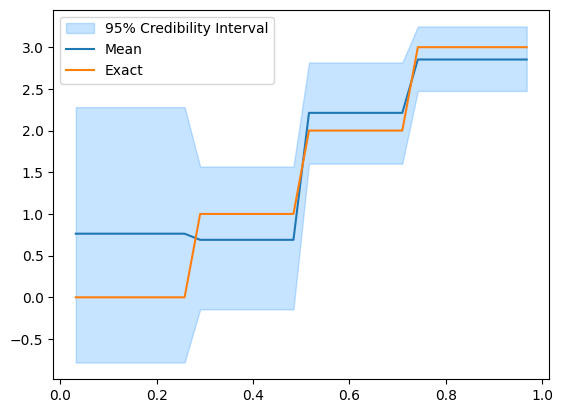

In [42]:
posterior_samples.burnthin(1000).plot_ci(95, exact=problemInfo.exactSolution)

We see that the credible interval is wider on the side of the domain where data is not available (the left side) and narrower as we get to the right side of the domain.

## 5. ★ Parametrizing the unknown parameters via KL expansion <a class="anchor" id="KL_expansion"></a>

Here we explore the Bayesian inversion for a more general exact solution. We parametrize the Bayesian parameters using Karhunen–Loève (KL) expansion. This will represent the inferred heat initial profile as a linear combination of sine functions. 

$$u(\xi_j,0) = \sum_{i=0}^{N-2} \left(\frac{1}{(i+1)^\gamma\tau_\mathrm{KL}}\right)  x_i \, \text{sin}\left(\frac{\pi}{N}(i+1)(j+\frac{1}{2})\right) + \frac{(-1)^j}{2}\left(\frac{1}{N^\gamma\tau_\mathrm{KL}}\right)  x_{N-1}$$

    
where $\xi_j$ is the $j^\text{th}$ grid point (in a regular grid), $j=0, 1, 2, 3, ..., N-1$, $N$ is the number of nodes in the grid, $\gamma$ is a decay rate, $\tau_\mathrm{KL}$ is a normalization constant, and $x_i$ are the expansion coefficients (the Bayesian parameters here). 

Let's load the `Heat1D` test case and pass `field_type = 'KL'`, which behind the scenes will set the domain geometry of the model to be a KL expansion geometry (See [`KLExpansion`](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.geometry/cuqi.geometry.KLExpansion.html#cuqi.geometry.KLExpansion) documentation for details): 

In [43]:
N = 35
model, data, problemInfo = Heat1D(
    dim=N,
    endpoint=L,
    max_time=tau_max,
    field_type="KL"
).get_components()


Now we inspect the `model`:

In [44]:
model

CUQI PDEModel: KLExpansion[35] -> Continuous1D[35].
    Forward parameters: ['x'].
    PDE: TimeDependentLinearPDE.

And the exact solution and the data:

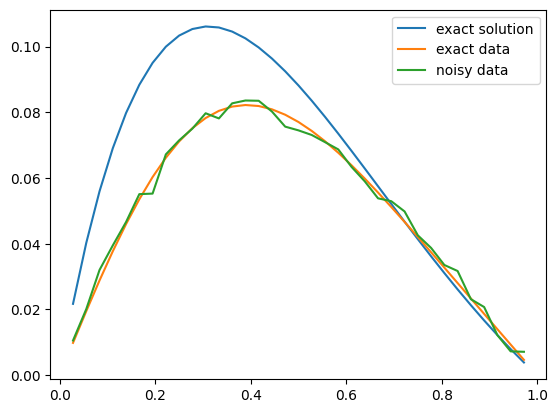

In [45]:
problemInfo.exactSolution.plot()
problemInfo.exactData.plot()
data.plot()
plt.legend(['exact solution', 'exact data', 'noisy data']);

Note that the exact solution here is a general signal that is not constructed from the basis functions. We define the prior $p(x)$ as an i.i.d multivariate Gaussian with variance $3^2$. We determined the choice of this variance value through trial and error approach to get a reasonable Bayesian reconstruction of the exact solution:

In [46]:
sigma_prior = 3*np.ones(model.domain_dim)
x = Gaussian(mean, sigma_prior**2, geometry=model.domain_geometry)

We define the data distribution:

In [47]:
sigma_noise = np.std(problemInfo.exactData - data)*np.ones(model.range_dim) # noise level
y = Gaussian(mean=model(x), cov=sigma_noise**2, geometry=model.range_geometry)

And the posterior distribution:

In [48]:
joint =  JointDistribution(y, x)
posterior = joint(y=data)

We sample the posterior, here we use Component-wise Metropolis Hastings (~70 seconds):

In [49]:
MySampler = CWMH(posterior, initial_point=np.ones(N))
MySampler.warmup(500, tune_freq=0.01)
MySampler.sample(1000)
posterior_samples = MySampler.get_samples()

Warmup: 100%|██████████| 500/500 [00:20<00:00, 24.25it/s]


Acceptance rate: 84.14%


Sample: 100%|██████████| 1000/1000 [00:40<00:00, 24.61it/s]

Acceptance rate: 84.21%


And plot the $95\%$ credibility interval (you can try plotting different credibility intervals, e.g. $80\%$) 

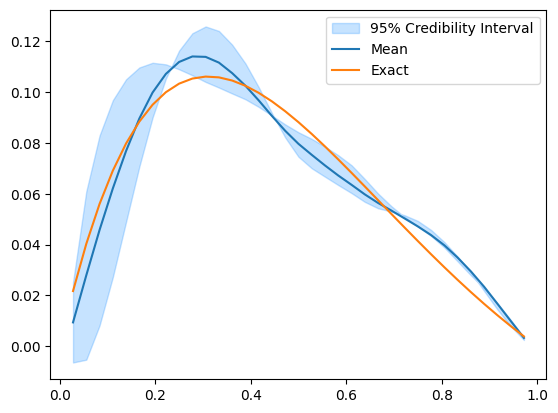

In [50]:
posterior_samples.plot_ci(95, exact=problemInfo.exactSolution)

The credibility interval can have zero width at some locations where the upper and lower limits seem to intersect and switch order (uppers becomes lower and vice versa). To look into what actually happen here, we plot some samples:

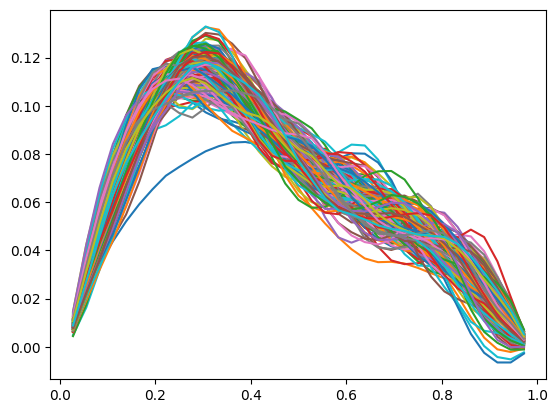

In [51]:
posterior_samples_burnthin = posterior_samples.burnthin(0,10)
for i, s in enumerate(posterior_samples_burnthin):
    model.domain_geometry.plot(s)

The samples seem to paint a different picture than what the credibility interval plot shows. Note that the computed credibility interval above, is computed on the domain geometry parameter space, then converted to the function space for plotting. We can alternatively convert the samples to function values first, then compute and plot the credibility interval.

Convert samples to function values:

In [52]:
funvals_samples = posterior_samples.funvals

Then plot the credibility interval computed from the function values:

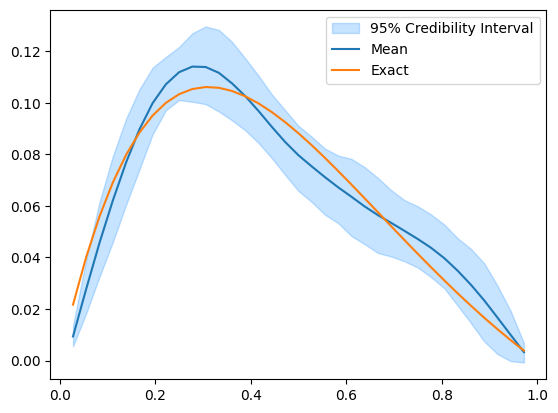

In [53]:
funvals_samples.plot_ci(95, exact=problemInfo.exactSolution)

We can see that the credibility interval now reflects what the samples plot shows and does not have these locations where the upper and lower bounds intersect.

Let's look at the effective sample size (ESS):

In [54]:
posterior_samples.compute_ess()

array([ 94.11603252, 163.26312982, 286.23052814,  48.67158365,
        14.7437873 ,  50.96477336,  44.36269618,  35.84251315,
        41.63115966,  43.29231008,  33.27747358,  41.22460698,
        19.40584567,  50.38227988,  45.39147349,  48.4253753 ,
        30.15070918,  25.39686987,  30.81382101,  27.51149249,
        50.37528424,  34.55200617,  47.61861415,  33.90790865,
        28.29053324,  35.31841284,  27.19067904,  59.80450291,
        27.5914881 ,  49.40899956,  31.53884584,  47.76752435,
        46.99341696,  44.55981745,  76.93608393])

We note that the ESS varies considerably among the variables. We can view the trace plot for, let's say, the first and the second variables:

array([[<Axes: title={'center': 'x0'}>, <Axes: title={'center': 'x0'}>],
       [<Axes: title={'center': 'x1'}>, <Axes: title={'center': 'x1'}>]],
      dtype=object)

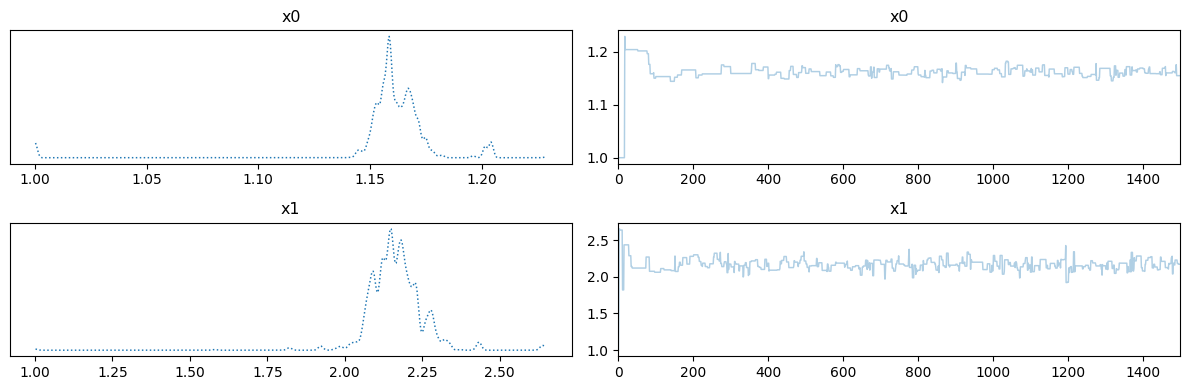

In [55]:
posterior_samples.plot_trace([0,1])

We note that the (as expected from the values of ESS) the chain quality of $x1$, which corresponds to the second coefficient in the KL expansion, is much better than that of the first variable $x0$. Low quality chain (where chain samples are highly correlated) indicates difficulty in exploring the corresponding parameter and possibly high sensitivity of the model to that particular parameter. Sampling methods that incorporate gradient information (which we do not explore in this notebook) are expected to work better in this situation. 

A third way of looking at the credibility intervals, is to look at the expansion coefficients  $x_i$ credibility intervals. We plot the credibility intervals for these coefficients from both prior  and posterior samples by passing the flag `plot_par=True` to `plot_ci` function:

The prior:

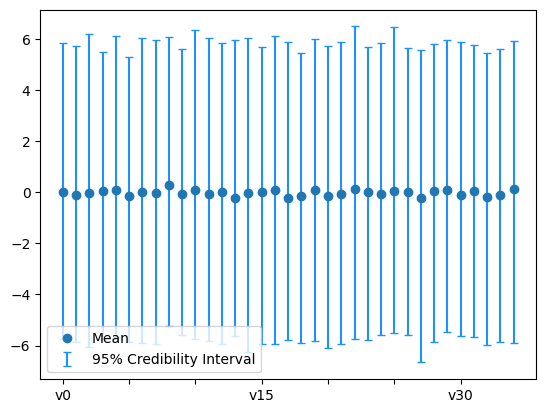

In [56]:
plt.figure()
x.sample(1000).plot_ci(95, plot_par=True)
plt.xticks(np.arange(x.dim)[::5]);

The posterior:

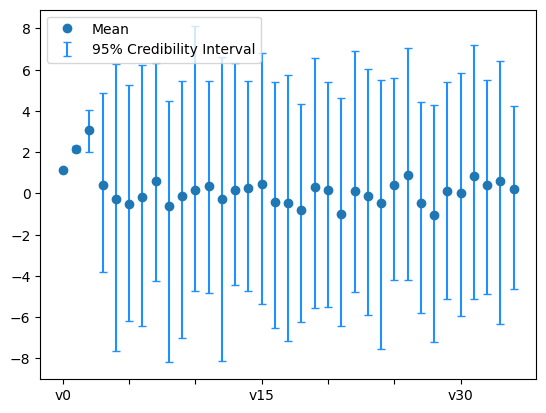

In [57]:
posterior_samples.plot_ci(95, plot_par=True)
plt.xticks(np.arange(x.dim)[::5]);

By comparing the two plots above, we see that the first few coefficients are inferred with higher certainty than the remaining coefficients. In parts, this is due to the nature of the Heat problem where high oscillatory initial heat features (corresponding to the higher modes in the expansion) will be smoothed out (lost) faster and thus are harder to retrieve based on measurements from the final solution.   